In [1]:
from pair_trading import *
import statsmodels.tsa.stattools as ts
from tqdm import tqdm
# import QuantConnect

In [2]:
# tickers = pd.read_csv('nasdaq_screener_1671416068616.csv')
# tickers 
# tk_ls = tickers.head(500).Symbol.to_list()

In [3]:
tickers = pd.read_csv('SP_500_Index.csv')
tk_ls = tickers.head(500).Symbol.to_list()

In [4]:
raw = yf.download(tk_ls, interval= '1d', start= '2021-09-01', end='2022-09-01', show_errors=True, progress=False)

# # raw = pd.read_csv('stock_raw.csv')
# dt = np.log(raw.loc[:,'Adj Close'])
# dt.to_csv('nasdaq_stock_raw.csv')
# print(dt.shape)
# dt.head()


2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [5]:
col_100 = raw['Adj Close'].columns[raw['Adj Close'].head(100).isna().sum()>0].tolist()


In [6]:
dt = raw['Adj Close'].drop(col_100, axis = 1).iloc[:-1, :]
dt = dt.drop(dt.columns[dt.isna().sum()>0].tolist(), axis = 1)

In [7]:
dt.columns[dt.isna().sum()>0]

Index([], dtype='object')

In [8]:
# dt.to_csv('nasdaq500_train_202107_202207.csv')

adf_dt = np.log(dt).diff().iloc[1:,]
adf_rst = adf_dt.apply(lambda x: adfuller(x)[0], axis = 0).sort_values()
# adf_rst


In [9]:
ind = adf_rst.loc[adf_rst < -7].index.tolist()

In [10]:
# dt.to_csv('sp500_mse_data.csv', index = False)

In [11]:
# m = adf_rst.shape[0]
# fdr = 0.01
# max([(x[0] + 1) if x[1]< fdr*(x[0] + 1)/m else 0 for x in enumerate(adf_rst.to_list())])
# # [adf_rst.to_list()]

In [12]:
train = dt.loc[:, ind]/dt.loc[:,ind].iloc[0, :]
# train.head()

In [13]:
%%time 
rst = {}
for n in tqdm(train.columns):
    x = train - train.loc[:, [n]].values
    if n not in rst:
        rst[n] = x.apply(lambda x: np.square(x).mean(), axis = 0).sort_values().head(11).to_dict()
        
    else:
        print(n)
    # break
# r = find_pairs(dt)
# r

100%|█████████████████████████████████████████| 480/480 [00:17<00:00, 26.89it/s]

CPU times: user 17.7 s, sys: 688 ms, total: 18.4 s
Wall time: 17.9 s


In [14]:
rs_ls = []
for k in rst.items():
    for in_k in k[1].items():
        if k[0] == in_k[0]:
            continue
        elif (in_k[0], k[0]) in rs_ls:
            continue
        else:
            rs_ls.append((k[0], in_k[0]))

In [15]:
candidates = sorted(rs_ls, key = lambda x: x[-1], reverse=False)
len(candidates)
# candidates

3429

In [148]:

# dt = raw
dt = yf.download(train.columns.tolist(), interval= '1d', start= '2021-09-30', end='2022-09-30', show_errors=True, progress=True)

[*********************100%***********************]  480 of 480 completed


In [149]:

def test_two_pairs(x_1, x_2):

    X = x_1
    X = sm.add_constant(X)
    model = sm.OLS(x_2, X)
    lm_rst = model.fit()
    result = adfuller(lm_rst.resid.values, regression = 'n')
    return result[1], lm_rst, result[0]


thrd = 0.001
ls = []
for cand_stock in tqdm(candidates):
    a, b= cand_stock
    # dt = yf.download([a, b], interval= '1h', start= '2022-05-01', end='2022-11-01', show_errors=True, progress=False)
    if dt['Adj Close'].loc[:, [a, b]].isna().mean().max() <= 0.03:
        dt_new = dt['Adj Close'].loc[:, [a, b]].dropna()
    else:
        # print(dt['Adj Close'].loc[:, [a, b]].isna().mean())
        continue
    # dt_new = np.log(dt_new)
    x1 = np.log(dt_new.iloc[:, 0])
    x2 = np.log(dt_new.iloc[:, 1])
    try:
        p, lm, t = test_two_pairs(x1, x2)
        if lm.params[-1] > 0:
            ls.append((a, b, p, t))
            
            
    except:
        print(dt_new.head(1))
        continue

100%|██████████████████████████████████████| 3429/3429 [00:16<00:00, 207.56it/s]


In [150]:
def show_pairs(x1, x2, start= '2020-01-01', end= '2022-06-01', intv = '1h', plotting = False):
    raw = yf.download([x1, x2], interval= intv, start=start, show_errors=False).dropna()

    dt = raw.loc[start:end,:]
    # print(dt.tail(3))
    test_dt = raw.loc[end:,:]
    X = np.log(dt.loc[:,'Adj Close'].iloc[:, 0])
    # X = dt.loc[:,'Adj Close'].iloc[:, 0]
    X = sm.add_constant(X)
    model = sm.OLS(np.log(dt.loc[:,'Adj Close'].iloc[:, 1]), X)
    # model = sm.OLS((dt.loc[:,'Adj Close'].iloc[:, 1]), X)
    rst = model.fit()
    # print(rst.summary())
    
    params = rst.params

    test_X = np.log(test_dt.loc[:,'Adj Close'].iloc[:, 0])
    # test_X = (test_dt.loc[:,'Adj Close'].iloc[:, 0])

    test_X = sm.add_constant(test_X)
    test_rst = np.log(test_dt.loc[:,'Adj Close'].iloc[:, 1])- rst.predict(test_X)
    # test_rst = (test_dt.loc[:,'Adj Close'].iloc[:, 1])- rst.predict(test_X)

    if plotting:
        print(dt.Close.tail(3))
        temp_dt = (raw.loc[:,'Adj Close'])#/raw.loc[:,'Adj Close'].iloc[0])
        # temp_dt.plot(figsize = (19, 7))
        # plt.show()
        # diff = (temp_dt.iloc[:, 0] - (temp_dt.mean()[0]/temp_dt.mean()[1])*temp_dt.iloc[:, 1])
        # diff.plot(figsize = (19, 7))
        # plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        # plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        # plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        # (dt.Close).plot(figsize = (19, 12))
        plt.show()
        print(rst.summary())
        diff = ((1/(1 + rst.params[-1]))*temp_dt.iloc[:, 1] - (rst.params[-1]/(1 + rst.params[-1]))*temp_dt.iloc[:, 0])
        diff.plot(figsize = (19, 7))
        plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.show()
        diff = (np.log(temp_dt.iloc[:, 1]) - (rst.params[-1])*np.log(temp_dt.iloc[:, 0]))
        diff.plot(figsize = (19, 7))
        plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-3* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 3* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.show()
        return rst, dt, test_X, test_rst
    else:
        return rst
    
def adf_rst(rst):
    result = adfuller(rst, regression='n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return result[1]

In [151]:
# sec_ls = []

# for k, v in r.items():
#     x1 = k
#     for v_2 in v:
#         try:
#             x2 = v_2[0]
#             rst = show_pairs(x1, x2)
#             p = adf_rst(rst.resid.values)
#             if p < 0.01:
#                 sec_ls.append((k, x2, p))
#         except:
#             continue
#     # break

In [152]:
def BH_test(ls, q = 0.05):
    sorted_ls = sorted(ls, key = lambda x: x[-1], reverse=False)
    m = len(ls)
    lab_ls = [(x[0] + 1) if x[1][2]< q*(x[0] + 1)/m else 0 for x in enumerate(sorted_ls) ]
    try:
        max_num = max(lab_ls)
        print(max_num)
    except:
        return []
    return sorted_ls[:max_num]
    

In [153]:
print(len(ls))
BH_test(ls, q=0.001)
# len(ls)

3426
12


[('BK', 'PNC', 2.908070065916268e-07, -5.28220977261415),
 ('AME', 'MLM', 2.947006287161548e-07, -5.279341061201665),
 ('AEE', 'ETR', 3.3240127309773564e-07, -5.253340210216114),
 ('EXPE', 'RHI', 4.512383111992708e-07, -5.187030520171073),
 ('AMGN', 'KO', 1.4372367973723167e-06, -4.93157991244259),
 ('LRCX', 'NVR', 1.4413477167838415e-06, -4.930941452342983),
 ('CB', 'RE', 1.8234124606815114e-06, -4.878225518850062),
 ('TRV', 'RE', 2.589642846629491e-06, -4.798983909318613),
 ('NTAP', 'STT', 2.6421640614754835e-06, -4.7944265277933615),
 ('ABC', 'LMT', 2.7784492149320136e-06, -4.78299994207669),
 ('LRCX', 'AOS', 2.785628324806231e-06, -4.782413251335371),
 ('BEN', 'TPR', 3.2013865743312896e-06, -4.750725558091295)]

[*********************100%***********************]  2 of 2 completed
                           AMGN         KO
Datetime                                  
2022-09-30 13:30:00  226.889999  56.415001
2022-09-30 14:30:00  226.740005  56.389999
2022-09-30 15:30:00  225.399994  56.080002
                            OLS Regression Results                            
Dep. Variable:                     KO   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1153.
Date:                Wed, 04 Jan 2023   Prob (F-statistic):          1.02e-125
Time:                        00:49:37   Log-Likelihood:                 1145.8
No. Observations:                 448   AIC:                            -2288.
Df Residuals:                     446   BIC:                            -2279.
Df Model:                           1                                         
Covar

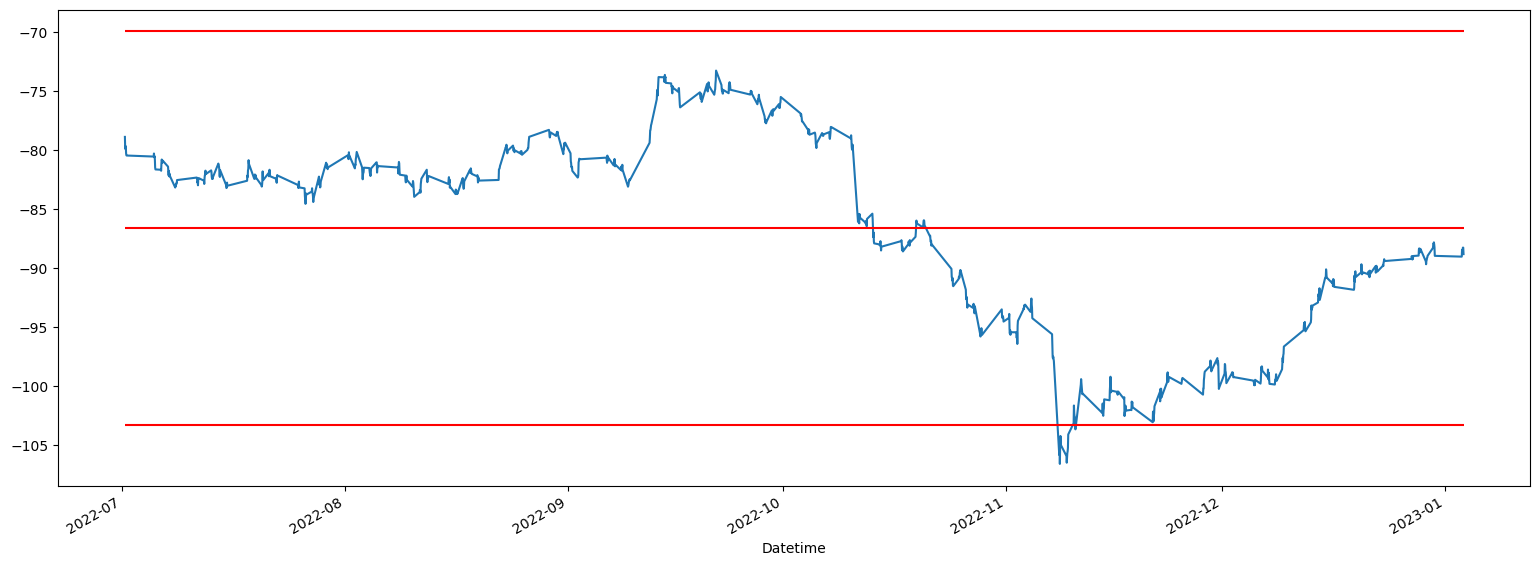

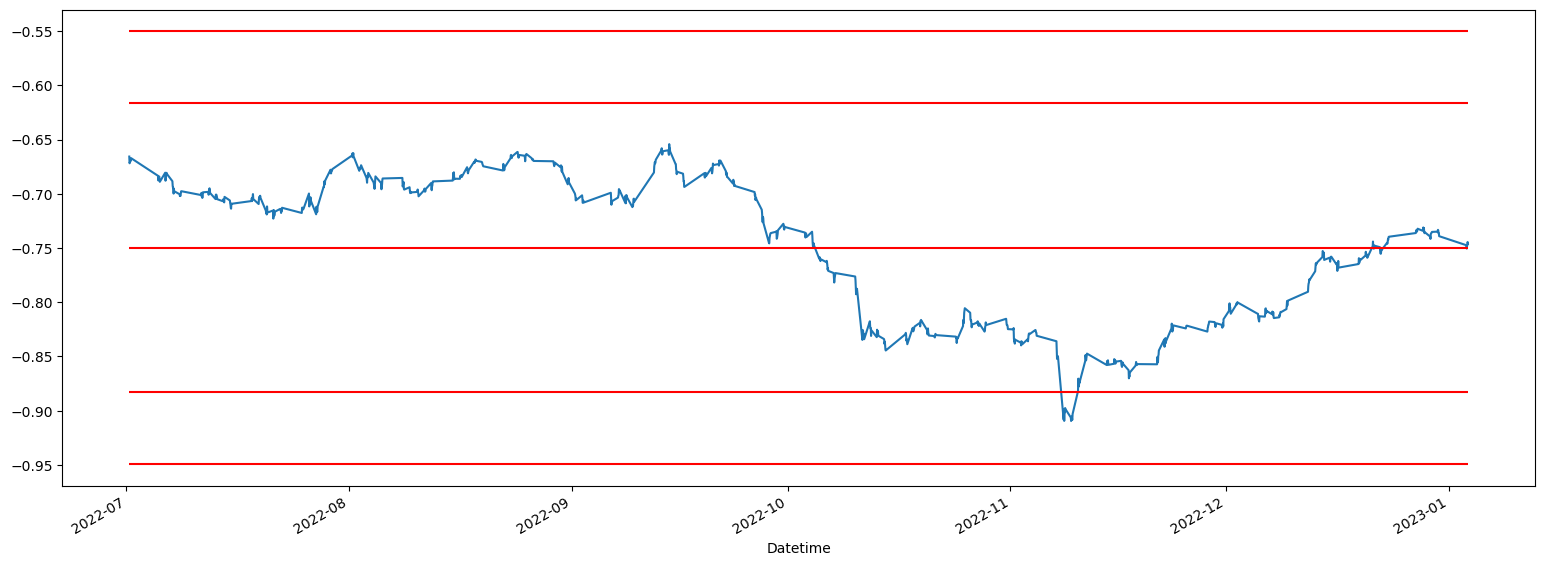

ADF Statistic: -1.782710
p-value: 0.070921


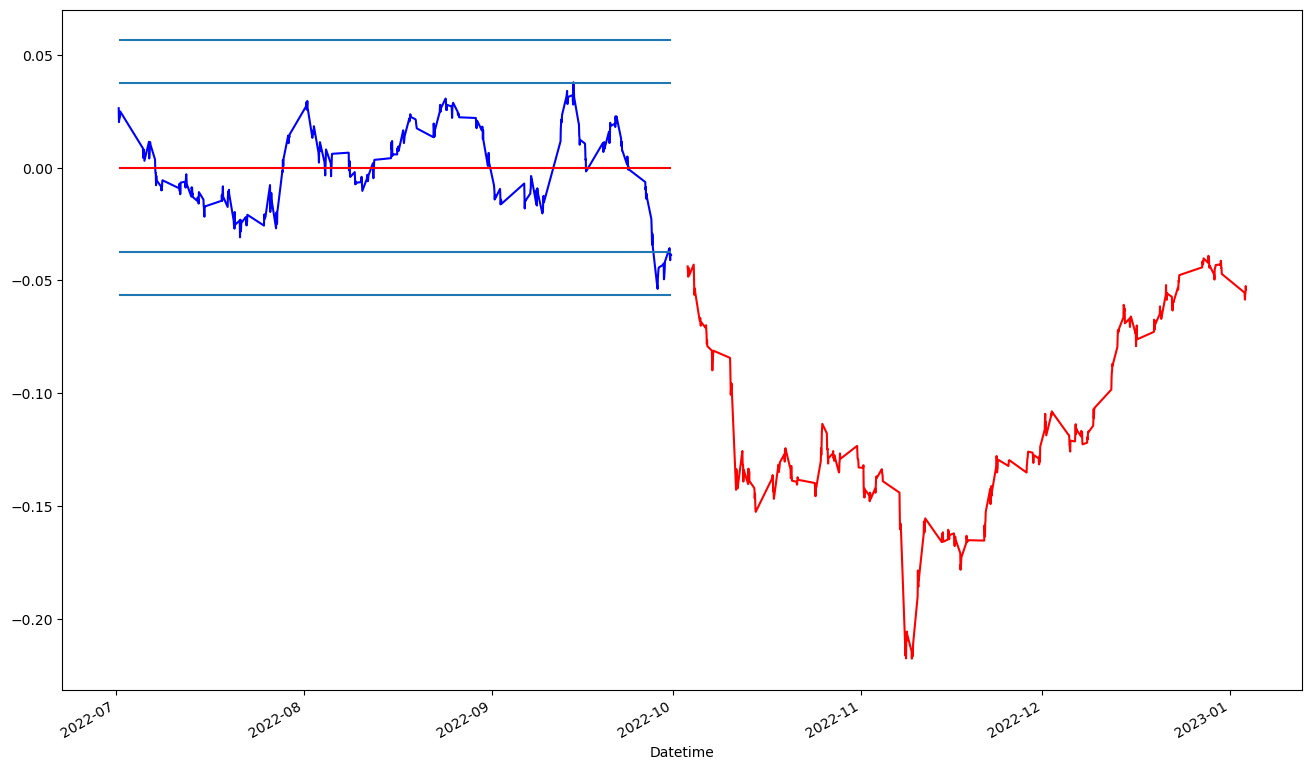

<AxesSubplot: >

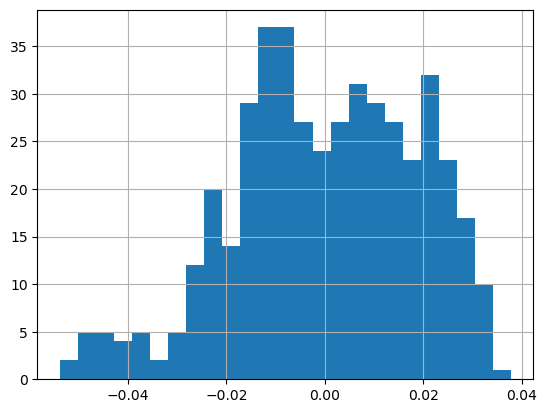

In [161]:
x1, x2 = 'AMGN', 'KO'
# 'MRO', 'EOG'
# 'HWM', 'GL'
# 'PTC', 'EA'
# 'MPWR', 'TMO'
# 'NXPI', 'EL'
# 'CPRT', 'AWK'
# 'IBM', 'JNJ'
# 'HST', 'KMI'
# 'XYL', 'A'
# 'fitb', 'rf'
# 'AEE', 'AEP'

# 'dow', 'lyb'

rst, dt, test_X, test_rst = show_pairs(x1=x1, x2=x2,start= '2022-07-01', end= '2022-10-01', plotting=True, intv='1h')
adf_rst(rst.resid.values)
from turtle import color


plt.figure(figsize=(16, 10))
(rst.resid).plot(color= 'blue')
plt.plot(test_rst,color = 'red')
plt.hlines(y=0, colors='red', xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=2*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=-2*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=3*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=-3*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.show()
rst.resid.hist(bins = 25)